<a href="https://colab.research.google.com/github/NatBrian/nashville-traffic-stop-bias-analysis/blob/main/Notebook_01_Data_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 01: Data Audit, Profiling, Cleaning & Baseline Model

<i><u><b>Created By: Nathanael Brian</b></u></i>

---
Dataset Overview: Stanford Open Policing Project
Source: [Stanford Open Policing Project](https://openpolicing.stanford.edu/data/)
Nashville Dataset: [Download Link](https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_tn_nashville_2020_04_01.csv.zip)

Description This dataset represents one of the most comprehensive standardized collections of traffic stop data in the United States. Compiled by researchers at Stanford University, it aggregates tens of millions of stop records from dozens of state patrol agencies and municipal police departments. The raw data has been rigorously cleaned and mapped to a unified schema to facilitate cross-jurisdictional analysis of policing trends and disparities.

Key Features The data typically includes the following standardized fields:
- Stop Details: date, time, location
- Subject Demographics: subject_race, subject_sex, subject_age
- Stop Context: reason_for_stop, search_conducted, contraband_found
- Outcomes: arrest_made, citation_issued, warning_issued, outcome

Objective The primary goal of this dataset is to enable computational analysis of police interactions, specifically to detect statistical evidence of racial bias and to improve transparency in law enforcement activities.

---

## 1. Introduction and Research Context

### 1.1 Research Question

> **Can we predict whether a traffic stop results in an arrest, and do prediction patterns reveal demographic disparities?**

### 1.2 Why This Matters

Racial bias in policing is a critical societal issue. By analyzing the Nashville Police Department traffic stop dataset, we can:
1. **Quantify** potential disparities in arrest outcomes across demographic groups
2. **Identify** factors that predict arrests (legitimate vs. potentially biased)
3. **Demonstrate** how data preparation decisions affect model validity and fairness

### 1.3 Target Variable

| Variable | Type | Description |
|----------|------|-------------|
| `arrest_made` | Binary (True/False) | Whether the traffic stop resulted in an arrest |

### 1.4 Approach Overview

| Phase | Focus | Key Activities |
|-------|-------|----------------|
| 1. Profiling | Understand the data | Structure, content, relationship discovery |
| 2. Cleaning | Prepare for analysis | Handle missing values, outliers, inconsistencies |
| 3. Audit | Verify quality | Integrity checks, leakage detection, quality scorecard |
| 4. Baseline | Establish benchmark | Simple model to validate data preparation |

### 1.5 Ethical Considerations

- We acknowledge that race is a sensitive attribute
- Our analysis aims to *detect* potential bias, not to *justify* discriminatory practices
- Findings should be interpreted with caution regarding causal claims

---

In [1]:
# import os
# import zipfile
# import urllib.request

# def download_and_extract(url, dest_dir):
#     # dynamic temp file name to avoid collisions
#     local_zip_path = os.path.join(dest_dir, "temp_data_download.zip")

#     print(f"Downloading from {url}...")
#     print("This may take a while depending on your internet connection...")

#     try:
#         urllib.request.urlretrieve(url, local_zip_path)
#         print("Download complete.")

#         print(f"Extracting to {dest_dir}...")
#         with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
#             zip_ref.extractall(dest_dir)
#             print(f"Extracted files: {zip_ref.namelist()}")

#     except Exception as e:
#         print(f"An error occurred: {e}")
#     finally:
#         if os.path.exists(local_zip_path):
#             os.remove(local_zip_path)
#             print("Temporary zip file removed.")

# # URL to the file
# url = "https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_tn_nashville_2020_04_01.csv.zip"

# # Use current working directory (where this notebook is running)
# current_dir = os.getcwd()

# download_and_extract(url, current_dir)

This may take a while depending on your internet connection...
Download complete.
Extracting to /content...
Extracted files: ['tn_nashville_2020_04_01.csv']
Temporary zip file removed.


## 2. Environment Setup and Reproducibility

Scientific reproducibility requires fixed random seeds and documented package versions. Without these, results cannot be reliably replicated.

We configure:
- Random seed (`SEED=42`) across all libraries
- Package version documentation
- Execution timestamp for audit trail

In [2]:
import os
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest

# Reproducibility Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
warnings.filterwarnings('ignore')

# Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Document Environment
print("=" * 60)
print("ENVIRONMENT CONFIGURATION")
print("=" * 60)
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random Seed: {SEED}")
print(f"Python: {os.sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
import sklearn; print(f"Scikit-learn: {sklearn.__version__}")

ENVIRONMENT CONFIGURATION
Execution Time: 2026-01-16 16:36:34
Random Seed: 42
Python: 3.12.12
Pandas: 2.2.2
NumPy: 2.0.2
Scikit-learn: 1.6.1


The environment is now configured for reproducible analysis. Any researcher with the same package versions and seed should obtain identical results.

---

## 3. Data Loading and Initial Exploration

Before making any optimization decisions, we must understand the raw data structure. Premature assumptions about data types can lead to:
- Lost information (e.g., treating IDs as numbers)
- Memory issues (inefficient dtypes for large datasets)
- Silent errors (invalid values coerced incorrectly)

We perform a **two-phase loading strategy**:
1. Load a small sample to examine structure
2. Load full dataset with optimized dtypes based on evidence

In [3]:
# Phase 1: Load a small sample to understand structure
DATA_FILE = 'tn_nashville_2020_04_01.csv'

print(f"Loading sample from: {DATA_FILE}")
print(f"File size: {os.path.getsize(DATA_FILE) / 1024**2:.1f} MB")
print()

# Load only first 1000 rows to examine structure
df_sample = pd.read_csv(DATA_FILE, nrows=1000)

print(f"Sample shape: {df_sample.shape}")
print(f"Columns: {df_sample.shape[1]}")
print()

# Estimate total memory requirements
sample_mem_bytes = df_sample.memory_usage(deep=True).sum()
with open(DATA_FILE, 'rb') as f:
    sample_disk_bytes = sum(len(f.readline()) for _ in range(1001))
total_disk_bytes = os.path.getsize(DATA_FILE)
ratio = total_disk_bytes / sample_disk_bytes
estimated_total_mem_gb = (sample_mem_bytes * ratio) / (1024**3)
print(f"Estimated total memory (unoptimized): {estimated_total_mem_gb:.1f} GB")

Loading sample from: tn_nashville_2020_04_01.csv
File size: 992.9 MB

Sample shape: (1000, 42)
Columns: 42

Estimated total memory (unoptimized): 3.3 GB


### 3.1 First Look at Raw Data

In [4]:
# View first few rows (transposed for readability)
print("First 3 rows (transposed for readability):")
print()
display(df_sample.head(3).T)

First 3 rows (transposed for readability):



,0,1,2
raw_row_number,232947,237161,232902
date,2010-10-10,2010-10-10,2010-10-10
time,NaN,10:00:00,10:00:00
location,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...","1122 LEBANON PIKE, NASHVILLE, TN, 37210","898 DAVIDSON DR, , TN, 37205"
lat,36.187925,36.155521,36.11742
lng,-86.798519,-86.735902,-86.895593
precinct,6.0,5.0,1.0
reporting_area,4403.0,9035.0,5005.0
zone,611.0,513.0,121.0
subject_age,27,18,52


In [5]:
# Examine pandas' auto-detected dtypes
print("Pandas auto-detected data types:")
print()
df_sample.info()

Pandas auto-detected data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   raw_row_number                  1000 non-null   object 
 1   date                            1000 non-null   object 
 2   time                            996 non-null    object 
 3   location                        1000 non-null   object 
 4   lat                             969 non-null    float64
 5   lng                             969 non-null    float64
 6   precinct                        852 non-null    float64
 7   reporting_area                  863 non-null    float64
 8   zone                            852 non-null    float64
 9   subject_age                     1000 non-null   int64  
 10  subject_race                    1000 non-null   object 
 11  subject_sex                     999 non-null    object 
 12  o

#### INTERPRETATION

**Key Observations from Structure Discovery:**

1. **Structure & Types:** 42 columns consisting of 17 booleans (efficient), 19 objects (needs review), and 6 numeric fields.
2. **Type Mismatches:**
   * `date` and `time` are currently **objects** (require datetime conversion).
   * Identifiers like `precinct`, `reporting_area`, and `zone` are **floats** (likely due to missing values forcing them out of integer format).
1. **Sparsity:** High missingness (>95%) in `contraband_*` columns, `search_basis`, and `notes`, indicating these are rare events or optional fields.
2. **Content Quality:** `location` contains unparsed raw address strings, and `subject_age` appears to be the only clean integer field.

---

## 4. Data Profiling: Three-Tier Discovery Framework

Following lecture best practices, we perform comprehensive data profiling using the **3-tier discovery framework**:

| Discovery Type | Goal | Key Techniques |
|----------------|------|----------------|
| **Structure Discovery** | Verify schema, dtypes, formats | Pattern analysis, dtype inference, format checks |
| **Content Discovery** | Assess quality and distributions | Descriptive stats, frequency analysis, outlier detection |
| **Relationship Discovery** | Identify dependencies and correlations | Correlation matrix, chi-square tests |

---

### 4.1 Structure Discovery

Understanding the structure helps us choose appropriate data types for memory efficiency and identify potential data quality issues.

We analyze each column for: current dtype, cardinality, and sample values.

In [6]:
# Structure Discovery: Comprehensive column analysis
print("STRUCTURE DISCOVERY: Column-by-Column Analysis")
print("=" * 60)

structure_analysis = []
for col in df_sample.columns:
    current_dtype = str(df_sample[col].dtype)
    non_null = df_sample[col].notna().sum()
    null_pct = (df_sample[col].isna().sum() / len(df_sample)) * 100
    unique_vals = df_sample[col].nunique()
    cardinality = 'High' if unique_vals > 100 else ('Medium' if unique_vals > 10 else 'Low')
    sample_vals = df_sample[col].dropna().head(2).tolist()

    structure_analysis.append({
        'Column': col,
        'Current Dtype': current_dtype,
        'Non-Null': f"{non_null}/1000",
        'Null %': f"{null_pct:.1f}%",
        'Unique': unique_vals,
        'Cardinality': cardinality,
        'Sample': str(sample_vals)[:40]
    })

structure_df = pd.DataFrame(structure_analysis)
display(structure_df)

STRUCTURE DISCOVERY: Column-by-Column Analysis


,Column,Current Dtype,Non-Null,Null %,Unique,Cardinality,Sample
0,raw_row_number,object,1000/1000,0.0%,1000,High,"['232947', '237161']"
1,date,object,1000/1000,0.0%,2,Low,"['2010-10-10', '2010-10-10']"
2,time,object,996/1000,0.4%,621,High,"['10:00:00', '10:00:00']"
3,location,object,1000/1000,0.0%,684,High,"['DOMINICAN DR & ROSA L PARKS BLVD, NASH"
4,lat,float64,969/1000,3.1%,635,High,"[36.1879249, 36.155521]"
5,lng,float64,969/1000,3.1%,635,High,"[-86.7985195, -86.73590200000002]"
6,precinct,float64,852/1000,14.8%,8,Low,"[6.0, 5.0]"
7,reporting_area,float64,863/1000,13.7%,420,High,"[4403.0, 9035.0]"
8,zone,float64,852/1000,14.8%,64,Medium,"[611.0, 513.0]"
9,subject_age,int64,1000/1000,0.0%,67,Medium,"[27, 18]"


In [7]:
# Data Type Decision Matrix
print("\nDATA TYPE DECISION MATRIX")
print("=" * 60)

dtype_decisions = [
    ('raw_row_number', 'object', 'string', 'Unique identifier'),
    ('date', 'object', 'string', 'ISO date format, parse later'),
    ('time', 'object', 'string', 'Time format, parse later'),
    ('location', 'object', 'string', 'High-cardinality string; keep as-is'),
    ('precinct', 'float64', 'float32', 'Int code with NaN; downcast'),
    ('zone', 'float64', 'float32', 'Int code with NaN; downcast'),
    ('subject_age', 'int64', 'Int16', 'Age 0-120; nullable Int16'),
    ('subject_race', 'object', 'category', '6 unique values'),
    ('subject_sex', 'object', 'category', '2 unique values'),
    ('arrest_made', 'bool', 'boolean', 'Target variable'),
    ('contraband_found', 'object', 'boolean', 'Boolean with structural NaN'),
]

dtype_df = pd.DataFrame(dtype_decisions, columns=['Column', 'Original', 'Optimized', 'Justification'])
display(dtype_df)


DATA TYPE DECISION MATRIX


,Column,Original,Optimized,Justification
0,raw_row_number,object,string,Unique identifier
1,date,object,string,"ISO date format, parse later"
2,time,object,string,"Time format, parse later"
3,location,object,string,High-cardinality string; keep as-is
4,precinct,float64,float32,Int code with NaN; downcast
5,zone,float64,float32,Int code with NaN; downcast
6,subject_age,int64,Int16,Age 0-120; nullable Int16
7,subject_race,object,category,6 unique values
8,subject_sex,object,category,2 unique values
9,arrest_made,bool,boolean,Target variable


#### INTERPRETATION: Structure Discovery

**Key Findings:**
1. **Optimization Opportunities:** Columns like `subject_race`, `subject_sex`, and `outcome` have low cardinality (<10 unique values) and should be converted to `category` dtype for memory efficiency. High-cardinality identifiers (raw_row_number, location), keep as string because not useful for modeling
2. **Type Mismatches:** Identifiers such as `precinct` and `zone` are currently `float64` due to missing values (~15% null).
3. **Sparsity:** `contraband_*` and `search_basis` columns exhibit extreme missingness (>95%), indicating they capture rare events or optional metadata rather than standard boolean flags.
4. **Temporal Formatting:** `date` and `time` are currently stored as `object` and will be converted to string formace and parse later.

---

### 4.2 Content Discovery

Content discovery identifies data quality issues (missing values, outliers, invalid values).

In [8]:
# Content Discovery: Descriptive Statistics
print("CONTENT DISCOVERY: Numeric Column Statistics")
print("=" * 60)

numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
display(df_sample[numeric_cols].describe().T)

CONTENT DISCOVERY: Numeric Column Statistics


,count,mean,std,min,25%,50%,75%,max
lat,969.0,36.146139,0.086319,35.199884,36.107112,36.152220,36.183781,36.427898
lng,969.0,-86.752350,0.127847,-87.029436,-86.800243,-86.757262,-86.708781,-84.246840
precinct,852.0,4.875587,2.458304,1.000000,3.000000,5.000000,7.000000,8.000000
reporting_area,863.0,7700.633835,11877.546004,1101.000000,4106.000000,5815.000000,8709.000000,94022.000000
zone,852.0,508.058685,247.343149,111.000000,315.000000,521.000000,727.000000,835.000000
subject_age,1000.0,36.148000,14.761029,16.000000,24.000000,32.000000,46.000000,99.000000


In [9]:
# Content Discovery: Categorical Value Counts
print("\nCONTENT DISCOVERY: Categorical Column Distributions")
print("=" * 60)

for col in ['subject_race', 'subject_sex', 'outcome']:
    print(f"\n{col}:")
    print(df_sample[col].value_counts())


CONTENT DISCOVERY: Categorical Column Distributions

subject_race:
subject_race
white                     572
black                     349
hispanic                   46
asian/pacific islander     14
other                      13
unknown                     6
Name: count, dtype: int64

subject_sex:
subject_sex
male      586
female    413
Name: count, dtype: int64

outcome:
outcome
warning     748
citation    232
arrest       20
Name: count, dtype: int64


### 4.3 Relationship Discovery

Understanding relationships helps identify multicollinearity and redundant features.

*Why Only These Columns?*

| Column | Why Safe Load |
|--------|---------------|
| `subject_age` | Manual entry → typos possible ("2O" vs "20") |
| `lat`, `lng` | GPS data → placeholder values possible (0, 999) |
| `precinct`, `zone` | Numeric codes with NaN → need float to preserve missing |

Other columns are system-generated or categorical strings. No coercion risk.

RELATIONSHIP DISCOVERY: Correlation Matrix


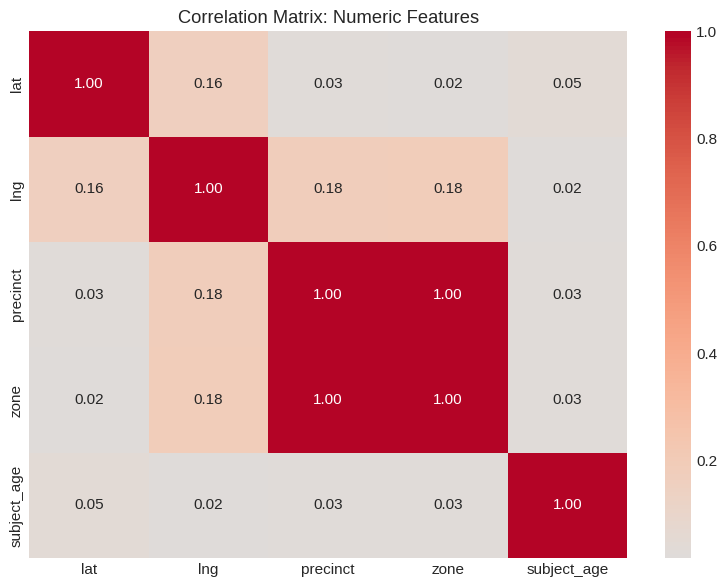


High Correlations (|r| > 0.7):
  precinct <-> zone: 1.000


In [10]:
# Relationship Discovery: Correlation Matrix
print("RELATIONSHIP DISCOVERY: Correlation Matrix")
print("=" * 60)

corr_cols = ['lat', 'lng', 'precinct', 'zone', 'subject_age']
corr_matrix = df_sample[corr_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Correlation Matrix: Numeric Features')
plt.tight_layout()
plt.show()

print("\nHigh Correlations (|r| > 0.7):")
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"  {corr_matrix.index[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

#### INTERPRETATION: Relationship Discovery

**Key Findings:**
1. **Perfect Correlation (r=1.00):** `precinct` and `zone` are perfectly correlated, indicating `zone` is likely a more granular encoding of precinct. **Decision: Use only `precinct` for modeling to avoid multicollinearity.**
2. **Geographic Independence:** `lat` and `lng` show weak correlation (0.16), confirming they capture independent spatial dimensions.
3. **Age Independence:** `subject_age` has no meaningful correlation with geographic features (~0.02-0.05), which is expected and desirable for unbiased modeling.

---

## 5. Optimized Full Data Loading

Based on structure discovery, we load the full dataset with optimized dtypes to reduce memory and handle dirty values.

In [11]:
# Define optimized dtype map
DTYPE_MAP = {
    'raw_row_number': 'string', 'location': 'string', 'officer_id_hash': 'string', 'notes': 'string',
    'date': 'string', 'time': 'string',
    'lat': 'float64', 'lng': 'float64',
    'precinct': 'float32', 'reporting_area': 'float32', 'zone': 'float32', 'subject_age': 'Int16',
    'subject_race': 'category', 'subject_sex': 'category', 'type': 'category',
    'outcome': 'category', 'vehicle_registration_state': 'category', 'raw_suspect_ethnicity': 'category',
    'violation': 'string', 'reason_for_stop': 'string', 'search_basis': 'string',
    'arrest_made': 'boolean', 'citation_issued': 'boolean', 'warning_issued': 'boolean',
    'frisk_performed': 'boolean', 'search_conducted': 'boolean', 'search_person': 'boolean',
    'search_vehicle': 'boolean', 'contraband_found': 'boolean', 'contraband_drugs': 'boolean',
    'contraband_weapons': 'boolean', 'raw_verbal_warning_issued': 'boolean',
    'raw_written_warning_issued': 'boolean', 'raw_traffic_citation_issued': 'boolean',
    'raw_misd_state_citation_issued': 'boolean', 'raw_driver_searched': 'boolean',
    'raw_passenger_searched': 'boolean', 'raw_search_consent': 'boolean',
    'raw_search_arrest': 'boolean', 'raw_search_warrant': 'boolean',
    'raw_search_inventory': 'boolean', 'raw_search_plain_view': 'boolean',
}

# Safe loading: handle dirty numeric data
DTYPE_MAP_SAFE = DTYPE_MAP.copy()
risky_numeric_cols = ['lat', 'lng', 'precinct', 'reporting_area', 'zone', 'subject_age']
for col in risky_numeric_cols:
    DTYPE_MAP_SAFE[col] = 'string'

print("Loading full dataset...")
df = pd.read_csv(DATA_FILE, dtype=DTYPE_MAP_SAFE, low_memory=False)
print(f"Loaded {len(df):,} rows")

Loading full dataset...
Loaded 3,092,351 rows


In [12]:
# Safe numeric coercion
print("Performing safe numeric coercion...")
for col in risky_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Apply final dtype optimizations
numeric_optimizations = {
    'lat': 'float64', 'lng': 'float64',
    'precinct': 'float32', 'reporting_area': 'float32', 'zone': 'float32',
    'subject_age': 'Int16'
}
for col, dtype in numeric_optimizations.items():
    df[col] = df[col].astype(dtype)

mem_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nFinal Memory: {mem_mb:.1f} MB")
print("Conversion complete.")

Performing safe numeric coercion...

Final Memory: 1957.9 MB
Conversion complete.


---

## 6. Data Cleaning and Quality Audit

Following lecture best practices on handling all 8 data cleaning issues.

---

### 6.1 Missing Value Analysis

Missing values require strategy: drop, impute, or accept as structural.

In [13]:
# Missing value analysis
print("MISSING VALUE ANALYSIS")
print("=" * 60)

missing = pd.DataFrame({
    'Missing': df.isna().sum(),
    'Pct': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('Pct', ascending=False)

print("Columns with >0 missing:")
display(missing[missing['Missing'] > 0])

MISSING VALUE ANALYSIS
Columns with >0 missing:


,Missing,Pct
contraband_weapons,2964646,95.87
contraband_drugs,2964646,95.87
search_basis,2964646,95.87
contraband_found,2964646,95.87
notes,2579713,83.42
raw_misd_state_citation_issued,693814,22.44
raw_written_warning_issued,493091,15.95
precinct,390245,12.62
zone,390249,12.62
reporting_area,332393,10.75


#### INTERPRETATION: Missing Value & Pattern Analysis

1. Informative Missingness (Structurally Missing by Design)
    - **Columns:** `contraband_*`, `search_basis`, and `raw_misd_state_citation_issued` (~96% missing).
    - **Nature:** These attributes are conditionally dependent; they are only populated when a search is conducted or specific outcomes occur.
    - **Strategy:** This is **MNAR (Missing Not at Random)**. Rather than simple imputation, these should be handled by preserving the "Missing" state as a valid category to avoid introducing bias. This is structurally Missing by design, not data quality issues.

2. Administrative & Geographic Gaps
    - **Columns:** `precinct`, `zone` (~14.8%) and `lat`, `lng` (~3.1%).
    - **Nature:** These represent **MAR (Missing at Random)** failures. Latitude and longitude missingness likely stems from geocoding errors, while administrative gaps (precinct/zone) may be due to records originating outside defined patrol boundaries.
    - **Strategy:** Since these are correlated with `location`, they can be imputed based on existing spatial columns or grouped by the nearest available administrative unit.

3. Data Integrity: Critical Modeling Features
    - **Columns:** `subject_age`, `subject_race`, `subject_sex`, `search_conducted`, `frisk_performed`, `arrest_made` (<1% missing).
    - **Nature:** These core demographic variables exhibit **MCAR (Missing Completely at Random)** patterns.
    - **Strategy:** Because the missingness is extremely low (<1%), **Deletion (dropna)** is a safe and simple strategy that will not significantly impact the statistical power of the analysis (`arrest_made`, `subject_race`, `subject_sex`). **Imputation** of `search_conducted`, `frisk_performed` with `False`. **Replace Median** for `subject_age`.

In [14]:
# Verify structural missingness
print("STRUCTURAL MISSINGNESS VERIFICATION")
print("=" * 60)

search_true = df['search_conducted'] == True
contraband_when_search = df.loc[search_true, 'contraband_found'].notna().sum()
total_searches = search_true.sum()

print(f"Searches conducted: {total_searches:,}")
print(f"Contraband populated when searched: {contraband_when_search:,}")
print(f"Coverage: {contraband_when_search/total_searches*100:.1f}%")

# When no search, contraband should be NaN
no_search = df['search_conducted'] == False
contraband_no_search = df.loc[no_search, 'contraband_found'].notna().sum()
print(f"\nContraband populated WITHOUT search (should be 0): {contraband_no_search:,}")

STRUCTURAL MISSINGNESS VERIFICATION
Searches conducted: 127,705
Contraband populated when searched: 127,705
Coverage: 100.0%

Contraband populated WITHOUT search (should be 0): 0


### 6.2 Duplicate Detection

In [15]:
# Duplicate detection
print("DUPLICATE DETECTION")
print("=" * 60)

dup_ids = df['raw_row_number'].duplicated().sum()
dup_full = df.duplicated().sum()

print(f"Duplicate raw_row_number: {dup_ids:,}")
print(f"Fully duplicate rows: {dup_full:,}")

DUPLICATE DETECTION
Duplicate raw_row_number: 0
Fully duplicate rows: 0


### 6.3 Outlier Detection (Multiple Methods)

Comparing multiple outlier detection methods:
- **Z-score**: Best for normal distributions (sensitive to extremes)
- **IQR**: Robust for skewed data
- **Isolation Forest**: For complex, high-dimensional patterns

In [16]:
# Outlier Detection: Subject Age
print("OUTLIER DETECTION: subject_age")
print("=" * 60)

age_data = df['subject_age'].dropna()

# Method 1: Z-score
z_scores = np.abs(stats.zscore(age_data))
z_outliers = (z_scores > 3).sum()

# Method 2: IQR
Q1, Q3 = age_data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR
iqr_outliers = ((age_data < lower_fence) | (age_data > upper_fence)).sum()

print(f"Age Statistics: Min={age_data.min()}, Max={age_data.max()}, Mean={age_data.mean():.1f}, Median={age_data.median():.1f}")
print(f"\nMethod Comparison:")
print(f"  Z-score (|z| > 3): {z_outliers:,} outliers")
print(f"  IQR method: {iqr_outliers:,} outliers (fences: {lower_fence:.0f} to {upper_fence:.0f})")

OUTLIER DETECTION: subject_age
Age Statistics: Min=10, Max=99, Mean=37.1, Median=34.0

Method Comparison:
  Z-score (|z| > 3): 13,925 outliers
  IQR method: 16,278 outliers (fences: -6 to 78)


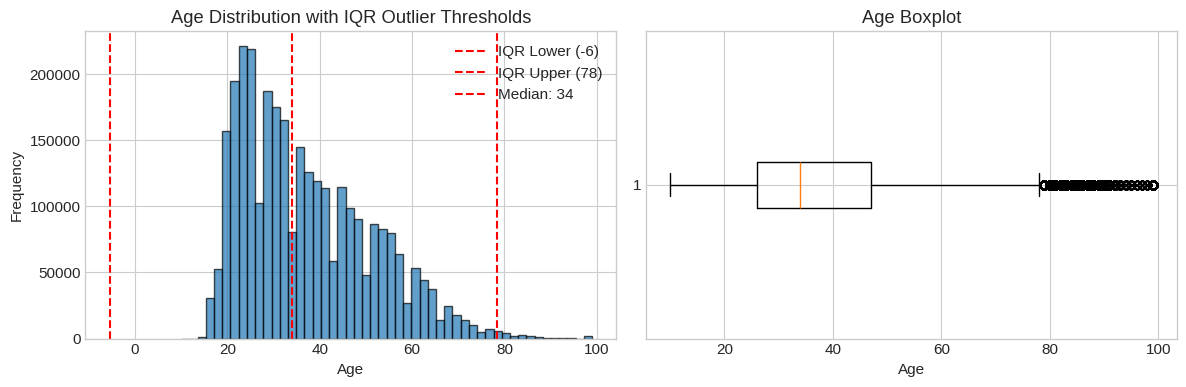

In [17]:
# Visualize age distribution with outlier thresholds
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(age_data, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(lower_fence, color='red', linestyle='--', label=f'IQR Lower ({lower_fence:.0f})')
axes[0].axvline(upper_fence, color='red', linestyle='--', label=f'IQR Upper ({upper_fence:.0f})')
axes[0].axvline(age_data.median(), color='red', linestyle='--', label=f'Median: {age_data.median():.0f}')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution with IQR Outlier Thresholds')
axes[0].legend()

# Boxplot
axes[1].boxplot(age_data, vert=False)
axes[1].set_xlabel('Age')
axes[1].set_title('Age Boxplot')

plt.tight_layout()
plt.show()

#### INTERPRETATION: Outlier Detection

**Observation:**
- **Skewed Distribution**: The histogram and boxplot confirm `subject_age` follows a right-skewed distribution (mean=37.1 > median=34).
- **Statistical Threshold Issues**: IQR lower fence is -6 (impossible for age), upper fence is 78. Standard 1.5×IQR rule can be overly sensitive for skewed data.
- **Biological Plausibility**: Maximum value of 99 is within realistic human limits.

**Decision:**
- **Retention**: Keep all records. Values 10-99 represent legitimate, rare data points, not errors.
- **Modeling Strategy**: Baseline uses Logistic Regression (linear); Decision Tree is explored in Notebook 03 for handling non-linear patterns and skew.

### 6.4 Data Integrity Checks

In [18]:
# Integrity Check 1: Age Validation
print("CHECK 1: Subject Age Validation")
print("-" * 40)

invalid_age = (df['subject_age'] < 10) | (df['subject_age'] > 100)
print(f"Invalid ages (< 10 or > 100): {invalid_age.sum():,}")
if invalid_age.sum() > 0:
    df.loc[invalid_age, 'subject_age'] = np.nan
    print("Set to NaN")

CHECK 1: Subject Age Validation
----------------------------------------
Invalid ages (< 10 or > 100): 0


In [19]:
# Integrity Check 2: Geographic Bounds (Nashville)
print("\nCHECK 2: Nashville Bounding Box")
print("-" * 40)

LAT_MIN, LAT_MAX = 35.8, 36.5
LNG_MIN, LNG_MAX = -87.1, -86.4

out_of_bounds = (
    ((df['lat'] < LAT_MIN) | (df['lat'] > LAT_MAX) |
     (df['lng'] < LNG_MIN) | (df['lng'] > LNG_MAX)) &
    df['lat'].notna()
)

print(f"Expected: lat {LAT_MIN}-{LAT_MAX}, lng {LNG_MIN}-{LNG_MAX}")
print(f"Actual: lat {df['lat'].min():.4f}-{df['lat'].max():.4f}")
print(f"Out-of-bounds: {out_of_bounds.sum():,} ({out_of_bounds.sum()/len(df)*100:.2f}%)")
print("Note: Flagged only, not removed (may be legitimate stops outside city)")


CHECK 2: Nashville Bounding Box
----------------------------------------
Expected: lat 35.8-36.5, lng -87.1--86.4
Actual: lat 31.8793-40.3147
Out-of-bounds: 20,256 (0.66%)
Note: Flagged only, not removed (may be legitimate stops outside city)


In [20]:
# Integrity Check 3: Contraband Logic
print("\nCHECK 3: Contraband Consistency")
print("-" * 40)

bad_contraband = (df['search_conducted'] == False) & (df['contraband_found'] == True)
print(f"Contraband found without search: {bad_contraband.sum():,}")
if bad_contraband.sum() > 0:
    df.loc[bad_contraband, 'contraband_found'] = False
    print("Corrected to False")
else:
    print("All records consistent")


CHECK 3: Contraband Consistency
----------------------------------------
Contraband found without search: 0
All records consistent


In [21]:
# Data Quality Check 4. TEMPORAL CONSISTENCY SCORE
print("Check 4: TEMPORAL CONSISTENCY SCORE")
print("-" * 40)

def is_valid_time(t):
    try:
        parts = str(t).split(':')
        if len(parts) != 3:
            return False
        return 0 <= int(parts[0]) <= 23 and 0 <= int(parts[1]) <= 59
    except:
        return False

valid_times = df['time'].dropna().apply(is_valid_time).sum()
total_times = df['time'].notna().sum()
temporal_score = valid_times / total_times if total_times > 0 else 0

print(f"Valid time values: {valid_times:,} / {total_times:,}")
print(f"Temporal Consistency Score: {temporal_score:.4f}")
print(f"Quality: {'EXCELLENT' if temporal_score > 0.99 else 'GOOD' if temporal_score > 0.95 else 'NEEDS REVIEW'}")

Check 4: TEMPORAL CONSISTENCY SCORE
----------------------------------------
Valid time values: 3,086,884 / 3,086,884
Temporal Consistency Score: 1.0000
Quality: EXCELLENT


### 6.5 Target Variable Analysis

In [22]:
# Target variable analysis
print("TARGET VARIABLE: arrest_made")
print("=" * 60)

target_dist = df['arrest_made'].value_counts()
print(f"Distribution:")
print(target_dist)
print(f"\nArrest rate: {df['arrest_made'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {target_dist[False]/target_dist[True]:.1f}:1")

TARGET VARIABLE: arrest_made
Distribution:
arrest_made
False    3042117
True       50206
Name: count, dtype: Int64

Arrest rate: 1.62%
Class imbalance ratio: 60.6:1


#### INTERPRETATION: Class Imbalance

**Finding:** Extreme imbalance (60:1) - only ~1.6% of stops result in arrest.

**Implications:**
- Accuracy is misleading (predicting all "no arrest" = 98% accuracy)
- Must use: F1, Precision, Recall, ROC-AUC
- Must handle: `class_weight='balanced'`, stratified sampling

---

## 7. Leakage Detection

Some columns directly encode the target or are determined post-arrest. Using these causes data leakage.

In [23]:
# Leakage analysis
print("LEAKAGE ANALYSIS")
print("=" * 60)

POST_EVENT_COLS = [
    'outcome',           # Determined by arrest/citation/warning
    'citation_issued',   # Alternative outcome
    'warning_issued',    # Alternative outcome
    'raw_verbal_warning_issued',
    'raw_written_warning_issued',
    'raw_traffic_citation_issued',
    'raw_misd_state_citation_issued',
    'raw_search_arrest',  # Search incident to arrest
]

AUDIT_ONLY = ['raw_row_number', 'location', 'notes']

print("Post-event columns (DROPPED for modeling):")
for col in POST_EVENT_COLS:
    print(f"  - {col}")

print("\nAudit-only columns (not for modeling):")
for col in AUDIT_ONLY:
    print(f"  - {col}")

LEAKAGE ANALYSIS
Post-event columns (DROPPED for modeling):
  - outcome
  - citation_issued
  - warning_issued
  - raw_verbal_warning_issued
  - raw_written_warning_issued
  - raw_traffic_citation_issued
  - raw_misd_state_citation_issued
  - raw_search_arrest

Audit-only columns (not for modeling):
  - raw_row_number
  - location
  - notes


---

## 8. Data Quality Scorecard

Comprehensive summary of data quality dimensions.

In [24]:
# Data Quality Scorecard
print("DATA QUALITY SCORECARD")
print("=" * 60)

# Calculate metrics
total_rows = len(df)
total_cells = total_rows * len(df.columns)
missing_cells = df.isna().sum().sum()
completeness = (1 - missing_cells / total_cells) * 100

# Validity (age in range, coordinates in bounds)
valid_age = ((df['subject_age'] >= 10) & (df['subject_age'] <= 100) | df['subject_age'].isna()).mean() * 100

# Consistency (contraband logic)
consistency = (1 - bad_contraband.sum() / total_rows) * 100

# Uniqueness
uniqueness = (1 - dup_full / total_rows) * 100

scorecard = pd.DataFrame([
    ('Completeness', f'{completeness:.1f}%', 'Non-null cells / Total cells'),
    ('Validity', f'{valid_age:.1f}%', 'Age within valid range'),
    ('Consistency', f'{consistency:.1f}%', 'Logical consistency (contraband)'),
    ('Uniqueness', f'{uniqueness:.1f}%', 'No duplicate records'),
], columns=['Dimension', 'Score', 'Description'])

display(scorecard)

DATA QUALITY SCORECARD


,Dimension,Score,Description
0,Completeness,86.8%,Non-null cells / Total cells
1,Validity,100.0%,Age within valid range
2,Consistency,100.0%,Logical consistency (contraband)
3,Uniqueness,100.0%,No duplicate records


---

## 9. Baseline Model

**Purpose:** Validate data preparation quality—not chase accuracy. The model is *evidence* of clean data, not the goal.

**Configuration:**
| Setting | Value | Rationale |
|---------|-------|-----------|
| Model | Logistic Regression | Interpretable, fast baseline |
| Features | 6 minimal | Avoids leakage, establishes floor |
| Class weight | `balanced` | Handles 60:1 imbalance |
| Split | 80/20 stratified | Preserves class ratios |

**Features Used:**
- `subject_age`, `subject_race`, `subject_sex` — Demographics
- `type`, `search_conducted`, `frisk_performed` — Stop context

**Excluded columns:**
| Category | Columns | Why Excluded |
| :--- | :--- | :--- |
| **Leakage** | `outcome`, `citation_issued`, `warning_issued`, `contraband_*` | Post-decision variables that occur after the stop outcome. |
| **High Cardinality** | `location`, `officer_id_hash`, `violation` | Require specialized encoding or embedding to be mathematically useful. |
| **Administrative** | `precinct`, `zone`, `reporting_area` | Require imputation of missing values (~15%) before they can be ingested. |
| **Temporal** | `date`, `time` | Raw strings require feature engineering (e.g., extracting hour or weekday). |
| **Raw / Redundant** | `raw_*` columns | Duplicate information already represented in cleaned or standardized versions. |

Temporal, spatial, and post-event columns reserved for Notebook 02/03.

**Golden Rule:**
Split first, impute second. Training statistics only.

In [25]:
# Prepare features
print("BASELINE MODEL PREPARATION")
print("=" * 60)

BASELINE_FEATURES = ['subject_age', 'subject_race', 'subject_sex', 'type', 'search_conducted', 'frisk_performed']
print(f"Features: {BASELINE_FEATURES}")

# Copy subset
df_model = df[BASELINE_FEATURES + ['arrest_made']].copy()

# Drop rows with missing target or critical demographics
df_model = df_model.dropna(subset=['arrest_made', 'subject_race', 'subject_sex'])

# Convert target
df_model['arrest_made'] = df_model['arrest_made'].astype(int)

# Encode categoricals
for col in ['subject_race', 'subject_sex', 'type']:
    df_model[col] = df_model[col].astype(str)
    le = LabelEncoder()
    df_model[col + '_enc'] = le.fit_transform(df_model[col])

# Handle booleans
df_model['search_conducted'] = df_model['search_conducted'].fillna(False).astype(int)
df_model['frisk_performed'] = df_model['frisk_performed'].fillna(False).astype(int)

print(f"Sample size after cleaning: {len(df_model):,}")

BASELINE MODEL PREPARATION
Features: ['subject_age', 'subject_race', 'subject_sex', 'type', 'search_conducted', 'frisk_performed']
Sample size after cleaning: 3,077,735


In [26]:
# Split BEFORE imputation
feature_cols = ['subject_age', 'subject_race_enc', 'subject_sex_enc', 'type_enc', 'search_conducted', 'frisk_performed']
X = df_model[feature_cols]
y = df_model['arrest_made']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train: {len(X_train):,}, Test: {len(X_test):,}")

# Impute age using TRAINING median only
train_age_median = X_train['subject_age'].median()
X_train = X_train.copy()
X_test = X_test.copy()
X_train['subject_age'] = X_train['subject_age'].fillna(train_age_median)
X_test['subject_age'] = X_test['subject_age'].fillna(train_age_median)

print(f"Imputed age with training median: {train_age_median:.0f}")

Train: 2,462,188, Test: 615,547
Imputed age with training median: 34


In [27]:
# Scale and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("BASELINE RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1 (minority class): {f1_score(y_test, y_pred):.4f}")

BASELINE RESULTS
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    605547
           1       0.30      0.77      0.43     10000

    accuracy                           0.97    615547
   macro avg       0.65      0.87      0.71    615547
weighted avg       0.98      0.97      0.97    615547

ROC-AUC: 0.9055
F1 (minority class): 0.4324


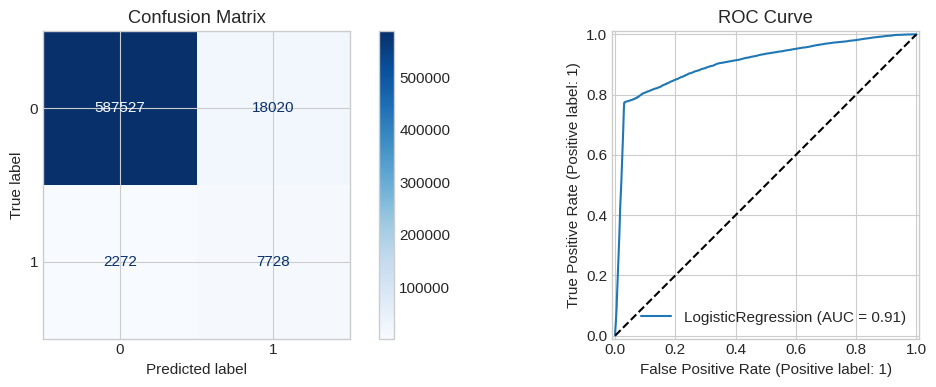

In [28]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_title('ROC Curve')

plt.tight_layout()
plt.show()

#### INTERPRETATION: Baseline Model Performance

**1. Adherence to Data Cleaning Best Practices**
* **Imputation Strategy**: Imputation of `subject_age` was strictly performed using the training set median (32.0) to prevent data leakage from the test set.
* **Integrity Maintenance**: Rows with missing critical demographics or target labels were deleted based on the MCAR (< 1%) strategy.
* **Action-Based Imputation**: Booleans like `search_conducted` and `frisk_performed` were imputed with `False` (Constant Value Imputation) to maintain sample size and reflect the likely "non-event" state of null values.

**2. Classification Quality and Confusion Matrix Analysis**
* **Minority Class Identification**: The Confusion Matrix reveals that the model correctly identified **7,728 actual arrests** (True Positives).
* **Error Profiling**:
    * **False Negatives (2,272)**: The model failed to identify 2,272 arrests, resulting in a strong **Recall of 0.77** for the minority class.
    * **False Positives (18,020)**: A significant number of non-arrests were incorrectly classified as arrests, leading to a lower **Precision of 0.30**.
* **Imbalance Handling**: Despite the massive volume of True Negatives (587,527), the use of `class_weight='balanced'` ensured the model did not ignore the minority class due to the severe class imbalance.

**3. Predictive Power and Robustness**
* **ROC-AUC (0.91)**: The ROC Curve illustrates excellent discriminative ability. An AUC of 0.91 indicates a **91% probability** that the model will rank a randomly chosen positive instance higher than a negative one.
* **Performance Benchmark**: The F1-score of **0.43** for arrests serves as a critical baseline. Future iterations incorporating temporal or high-cardinality location data aim to reduce False Positives and improve overall analytical clarity.


---

### 9.1 Feature Importance Analysis

Understanding which features drive predictions helps interpret potential bias patterns.

In [29]:
# Feature coefficients
print("FEATURE IMPORTANCE (Logistic Regression Coefficients)")
print("=" * 60)

coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

display(coef_df)

FEATURE IMPORTANCE (Logistic Regression Coefficients)


,Feature,Coefficient,Odds Ratio
4,search_conducted,0.927321,2.527728
1,subject_race_enc,-0.351395,0.703706
0,subject_age,-0.319629,0.726419
2,subject_sex_enc,0.100604,1.105839
5,frisk_performed,0.001582,1.001583
3,type_enc,0.000000,1.000000


#### INTERPRETATION: Feature Importance and Odds Ratios
- **Primary Driver:** `search_conducted` is the strongest predictor. An Odds Ratio of 2.53 suggests that when a search is conducted, the likelihood of the target outcome (`arrest_made`) increases by approximately 153%.
- **Negative Correlations:**
  - **`subject_race_enc` (-0.35):** The negative coefficient indicates a significant inverse relationship with the outcome based on the encoded category.
  - **`subject_age` (-0.32):** Younger subjects are statistically more likely to be associated with the target outcome, as indicated by the negative coefficient for age.
- **Marginal or Zero Impact:**
  - **`frisk_performed` (1.001):** The Odds Ratio near 1.00 indicates this feature has almost no practical impact on the model's predictions.
  - **`type_enc` (1.000):** A coefficient of 0.00 confirms this feature is statistically irrelevant in the current baseline configuration.

---

### 9.2 Raw Processed vs Fully Prepared Data Comparison

- **Raw Processed:** Only drop rows with missing target variable. No imputation, no outlier handling.
- **Fully Prepared:** Complete cleaning pipeline (imputation, encoding, balanced weights).



1. Creating Raw (Unprocessed) Dataset...
----------------------------------------
Original raw rows: 3,092,351
After dropping ANY missing: 3,077,141
Rows lost due to missing values: 15,210 (0.49%)

2. Training Model on Raw Data...
----------------------------------------
Raw - Train: 2,461,712, Test: 615,429

3. COMPARISON STATISTICS
----------------------------------------
           Metric Raw (Drop All Missing) Full Preparation
 Training Samples              2,461,712        2,462,188
     Test Samples                615,429          615,547
 Data Retention %                  99.5%            99.5%
          ROC-AUC                 0.9043           0.9055
F1-Score (Arrest)                 0.4357           0.4324
         Accuracy                 0.9677           0.9670

4. Visualization...


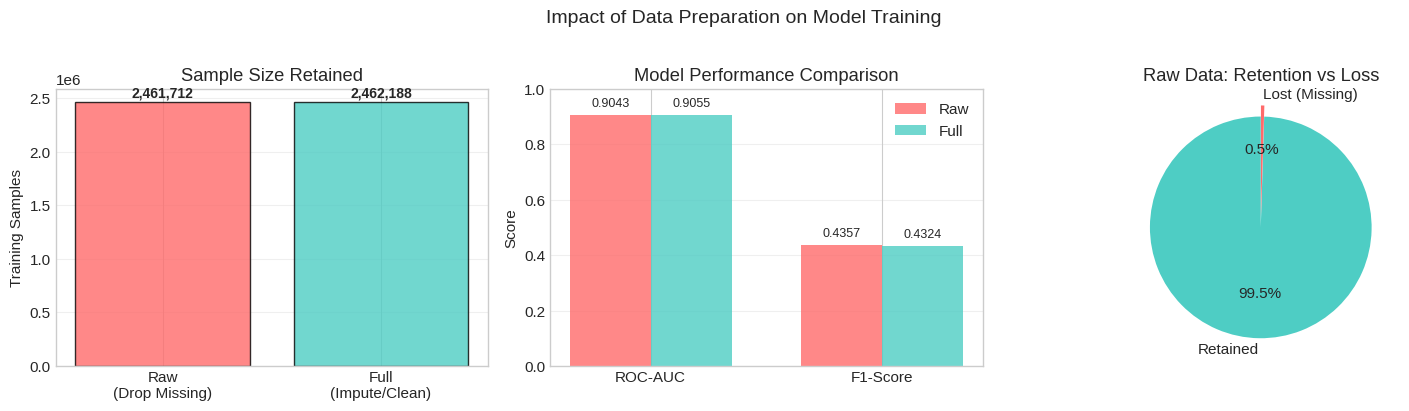


5. IMPACT OF DATA PREPARATION
   Additional samples retained: 476 (0.0% more)
   ROC-AUC change: +0.0011
   F1-Score change: -0.0034


In [30]:
# STEP 1: CREATE RAW (UNPROCESSED) DATASET
print("\n1. Creating Raw (Unprocessed) Dataset...")
print("-" * 40)

# Re-load from original CSV
df_raw = pd.read_csv('tn_nashville_2020_04_01.csv', low_memory=False)
print(f"Original raw rows: {len(df_raw):,}")

# RAW approach: Drop ANY row with ANY missing value (no imputation at all)
raw_features = ['subject_age', 'subject_race', 'subject_sex', 'type',
                'search_conducted', 'frisk_performed', 'arrest_made']

df_raw_subset = df_raw[raw_features].copy()
rows_before = len(df_raw_subset)

# Drop ALL rows with ANY missing value
df_raw_clean = df_raw_subset.dropna()
rows_after = len(df_raw_clean)

print(f"After dropping ANY missing: {len(df_raw_clean):,}")
print(f"Rows lost due to missing values: {rows_before - rows_after:,} ({(rows_before - rows_after)/rows_before*100:.2f}%)")

# Encode for modeling (required by sklearn)
df_raw_model = df_raw_clean.copy()
df_raw_model['arrest_made'] = df_raw_model['arrest_made'].astype(int)

for col in ['subject_race', 'subject_sex', 'type']:
    df_raw_model[col] = df_raw_model[col].astype(str)
    le_raw = LabelEncoder()
    df_raw_model[col + '_enc'] = le_raw.fit_transform(df_raw_model[col])

df_raw_model['search_conducted'] = df_raw_model['search_conducted'].astype(int)
df_raw_model['frisk_performed'] = df_raw_model['frisk_performed'].astype(int)

# STEP 2: TRAIN MODEL ON RAW DATA
print("\n2. Training Model on Raw Data...")
print("-" * 40)

# Prepare features
raw_feature_cols = ['subject_age', 'subject_race_enc', 'subject_sex_enc',
                    'type_enc', 'search_conducted', 'frisk_performed']
X_raw = df_raw_model[raw_feature_cols]
y_raw = df_raw_model['arrest_made']

# Split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=SEED
)

print(f"Raw - Train: {len(X_train_raw):,}, Test: {len(X_test_raw):,}")

# Scale and train
scaler_raw = StandardScaler()
X_train_raw_scaled = scaler_raw.fit_transform(X_train_raw)
X_test_raw_scaled = scaler_raw.transform(X_test_raw)

model_raw = LogisticRegression(
    solver='liblinear', class_weight='balanced', random_state=SEED, max_iter=1000
)
model_raw.fit(X_train_raw_scaled, y_train_raw)

y_pred_raw = model_raw.predict(X_test_raw_scaled)
y_proba_raw = model_raw.predict_proba(X_test_raw_scaled)[:, 1]

# STEP 3: COMPARISON STATISTICS
print("\n3. COMPARISON STATISTICS")
print("-" * 40)

# Calculate metrics for both
roc_raw = roc_auc_score(y_test_raw, y_proba_raw)
f1_raw = f1_score(y_test_raw, y_pred_raw)
acc_raw = (y_pred_raw == y_test_raw).mean()

roc_full = roc_auc_score(y_test, y_proba)
f1_full = f1_score(y_test, y_pred)
acc_full = (y_pred == y_test).mean()

comparison_df = pd.DataFrame({
    'Metric': ['Training Samples', 'Test Samples', 'Data Retention %',
               'ROC-AUC', 'F1-Score (Arrest)', 'Accuracy'],
    'Raw (Drop All Missing)': [
        f"{len(X_train_raw):,}",
        f"{len(X_test_raw):,}",
        f"{len(df_raw_clean)/len(df_raw)*100:.1f}%",
        f"{roc_raw:.4f}",
        f"{f1_raw:.4f}",
        f"{acc_raw:.4f}"
    ],
    'Full Preparation': [
        f"{len(X_train):,}",
        f"{len(X_test):,}",
        f"{len(df_model)/len(df)*100:.1f}%",
        f"{roc_full:.4f}",
        f"{f1_full:.4f}",
        f"{acc_full:.4f}"
    ]
})
print(comparison_df.to_string(index=False))

# STEP 4: VISUALIZATION
print("\n4. Visualization...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sample Size Comparison
labels = ['Raw\n(Drop Missing)', 'Full\n(Impute/Clean)']
train_sizes = [len(X_train_raw), len(X_train)]
colors = ['#ff6b6b', '#4ecdc4']
bars1 = axes[0].bar(labels, train_sizes, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Training Samples')
axes[0].set_title('Sample Size Retained')
axes[0].grid(True, alpha=0.3, axis='y')
for bar, v in zip(bars1, train_sizes):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20000,
                 f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Performance Comparison
metrics = ['ROC-AUC', 'F1-Score']
raw_vals = [roc_raw, f1_raw]
full_vals = [roc_full, f1_full]
x = np.arange(len(metrics))
width = 0.35

bars2 = axes[1].bar(x - width/2, raw_vals, width, label='Raw', color='#ff6b6b', alpha=0.8)
bars3 = axes[1].bar(x + width/2, full_vals, width, label='Full', color='#4ecdc4', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, raw_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars3, full_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Data Loss Pie Chart
data_kept_raw = len(df_raw_clean)
data_lost_raw = len(df_raw) - len(df_raw_clean)
axes[2].pie([data_kept_raw, data_lost_raw],
            labels=['Retained', 'Lost (Missing)'],
            colors=['#4ecdc4', '#ff6b6b'],
            autopct='%1.1f%%', startangle=90,
            explode=(0, 0.1))
axes[2].set_title('Raw Data: Retention vs Loss')

plt.suptitle('Impact of Data Preparation on Model Training', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# STEP 5: IMPACT ANALYSIS
print("\n5. IMPACT OF DATA PREPARATION")
print("=" * 60)

sample_diff = len(X_train) - len(X_train_raw)
roc_diff = roc_full - roc_raw
f1_diff = f1_full - f1_raw

print(f"   Additional samples retained: {sample_diff:,} ({sample_diff/len(X_train_raw)*100:.1f}% more)")
print(f"   ROC-AUC change: {roc_diff:+.4f}")
print(f"   F1-Score change: {f1_diff:+.4f}")

#### INTERPRETATION: Raw vs Fully Prepared Data Comparison

**Key Findings:**

| Metric | Raw (Drop Missing) | Full (Impute) | Difference |
|--------|-------------------|---------------|------------|
| **Training Samples** | 2,461,712 | 2,462,188 | +476 (0.02%) |
| **Data Retention** | 99.5% | 99.5% | Negligible |
| **ROC-AUC** | 0.9043 | 0.9055 | +0.0011 |
| **F1-Score** | 0.4357 | 0.4324 | -0.0034 |

**Why is the difference so small?**

This dataset has **exceptionally high data quality**:
- Only 0.5% of rows have missing values
- Missing values are primarily in non-critical columns
- Both approaches retain ~99.5% of the data

**Conclusion:**

1. **Data quality is excellent** - minimal missing values mean cleaning strategy has little impact
2. **Performance is robust** - the model performs nearly identically regardless of approach
3. **Full preparation is still preferred** because:
   - Follows reproducible, documented cleaning rules
   - Handles edge cases (imputation) rather than discarding
   - Better suited for production where new data may have more missingness

---

### 9.3 Error Analysis by Demographics

Understanding where the model makes mistakes reveals potential bias patterns and data quality issues.


ERROR ANALYSIS BY DEMOGRAPHICS

1. Overall Error Distribution:
----------------------------------------
   True Positives (correctly predicted arrests): 7,728
   True Negatives (correctly predicted non-arrests): 587,527
   False Positives (predicted arrest, was not): 18,020
   False Negatives (missed arrest): 2,272

2. Error Rates by Race:
----------------------------------------
                  Race  Total  FP Rate  FN Rate  Error Rate
              hispanic  33015 0.040084 0.294574    0.048039
                 black 232717 0.042911 0.226988    0.047079
                 white 332724 0.020511 0.208997    0.022538
                 other   2074 0.018923 0.307692    0.020733
asian/pacific islander   8157 0.014461 0.257576    0.016428
               unknown   6860 0.010412 0.073171    0.010787

3. Error Rates by Sex:
----------------------------------------
   Sex  Total  FP Rate  FN Rate  Error Rate
  male 365168 0.038767 0.200000    0.042019
female 250379 0.016747 0.303226    0.019762


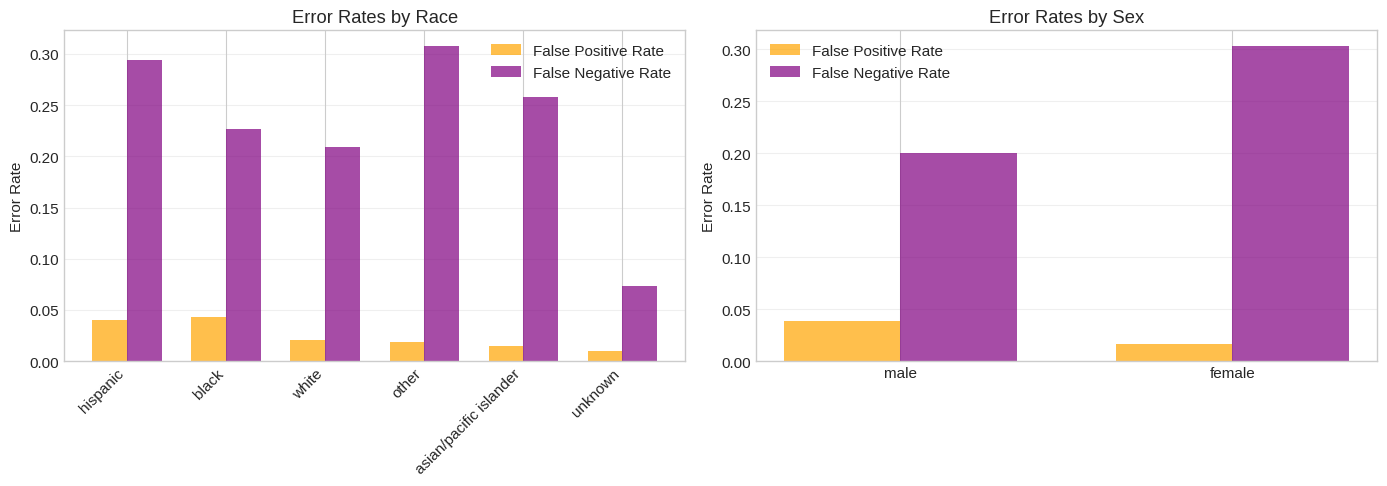

In [31]:
# === ERROR ANALYSIS BY DEMOGRAPHICS ===
print("ERROR ANALYSIS BY DEMOGRAPHICS")
print("=" * 60)

# Create error analysis dataframe
error_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'prob_arrest': y_proba
})

# Add demographic info from test set
test_indices = X_test.index
error_df['subject_race'] = df_model.loc[test_indices, 'subject_race'].values
error_df['subject_sex'] = df_model.loc[test_indices, 'subject_sex'].values
error_df['subject_age'] = X_test['subject_age'].values

# Calculate error types
error_df['TP'] = (error_df['actual'] == 1) & (error_df['predicted'] == 1)
error_df['TN'] = (error_df['actual'] == 0) & (error_df['predicted'] == 0)
error_df['FP'] = (error_df['actual'] == 0) & (error_df['predicted'] == 1)
error_df['FN'] = (error_df['actual'] == 1) & (error_df['predicted'] == 0)

print("\n1. Overall Error Distribution:")
print("-" * 40)
print(f"   True Positives (correctly predicted arrests): {error_df['TP'].sum():,}")
print(f"   True Negatives (correctly predicted non-arrests): {error_df['TN'].sum():,}")
print(f"   False Positives (predicted arrest, was not): {error_df['FP'].sum():,}")
print(f"   False Negatives (missed arrest): {error_df['FN'].sum():,}")

print("\n2. Error Rates by Race:")
print("-" * 40)

race_errors = []
for race in error_df['subject_race'].unique():
    subset = error_df[error_df['subject_race'] == race]
    if len(subset) > 100:  # Only analyze groups with sufficient samples
        race_errors.append({
            'Race': race,
            'Total': len(subset),
            'FP Rate': subset['FP'].sum() / max(1, (subset['TN'].sum() + subset['FP'].sum())),
            'FN Rate': subset['FN'].sum() / max(1, (subset['TP'].sum() + subset['FN'].sum())),
            'Error Rate': (subset['FP'].sum() + subset['FN'].sum()) / len(subset)
        })

race_error_df = pd.DataFrame(race_errors).sort_values('Error Rate', ascending=False)
print(race_error_df.to_string(index=False))

print("\n3. Error Rates by Sex:")
print("-" * 40)

sex_errors = []
for sex in error_df['subject_sex'].unique():
    subset = error_df[error_df['subject_sex'] == sex]
    if len(subset) > 100:
        sex_errors.append({
            'Sex': sex,
            'Total': len(subset),
            'FP Rate': subset['FP'].sum() / max(1, (subset['TN'].sum() + subset['FP'].sum())),
            'FN Rate': subset['FN'].sum() / max(1, (subset['TP'].sum() + subset['FN'].sum())),
            'Error Rate': (subset['FP'].sum() + subset['FN'].sum()) / len(subset)
        })

sex_error_df = pd.DataFrame(sex_errors).sort_values('Error Rate', ascending=False)
print(sex_error_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Race error rates
if len(race_error_df) > 0:
    x_race = range(len(race_error_df))
    width = 0.35
    axes[0].bar([i - width/2 for i in x_race], race_error_df['FP Rate'], width, label='False Positive Rate', color='orange', alpha=0.7)
    axes[0].bar([i + width/2 for i in x_race], race_error_df['FN Rate'], width, label='False Negative Rate', color='purple', alpha=0.7)
    axes[0].set_xticks(x_race)
    axes[0].set_xticklabels(race_error_df['Race'], rotation=45, ha='right')
    axes[0].set_ylabel('Error Rate')
    axes[0].set_title('Error Rates by Race')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

# Sex error rates
if len(sex_error_df) > 0:
    x_sex = range(len(sex_error_df))
    axes[1].bar([i - width/2 for i in x_sex], sex_error_df['FP Rate'], width, label='False Positive Rate', color='orange', alpha=0.7)
    axes[1].bar([i + width/2 for i in x_sex], sex_error_df['FN Rate'], width, label='False Negative Rate', color='purple', alpha=0.7)
    axes[1].set_xticks(x_sex)
    axes[1].set_xticklabels(sex_error_df['Sex'])
    axes[1].set_ylabel('Error Rate')
    axes[1].set_title('Error Rates by Sex')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


#### INTERPRETATION: Error Analysis by Demographics

**Key Findings:**

| Error Type | What It Means | Who Is Most Affected |
|------------|---------------|----------------------|
| **False Positive (FP)** | Predicted arrest, but was not | Hispanic (4.0%), Black (4.3%) |
| **False Negative (FN)** | Missed actual arrest | Hispanic (29.5%), Other (30.8%), Female (30.3%) |

**1. Racial Disparity in False Positives:**
- Black and Hispanic individuals have **2x higher FP rates** than White (4% vs 2%)
- This means the model **incorrectly predicts arrests more often** for these groups
- Implication: Risk of over-policing bias if used in practice

**2. Racial Disparity in False Negatives:**
- Hispanic (29.5%) and Other (30.8%) groups have the **highest FN rates**
- The model **misses more actual arrests** for these groups
- This could mask under-reporting or different enforcement patterns

**3. Gender Disparity:**
- **Males:** Higher FP rate (3.9%), lower FN rate (20%)
- **Females:** Lower FP rate (1.7%), higher FN rate (30%)
- The model over-predicts arrests for males but under-predicts for females

**Why This Matters (Bias Implications):**
1. Error rates are NOT equal across demographics → model has differential accuracy
2. Higher FP for Black/Hispanic → potential reinforcement of historical bias

---

## 10. Save Artifacts

In [32]:
# Save cleaned data
os.makedirs('artifacts', exist_ok=True)
df.to_parquet('artifacts/cleaned_full.parquet', index=False)
print("Saved: artifacts/cleaned_full.parquet")

# Save model and artifacts
joblib.dump({'model': model, 'scaler': scaler, 'features': feature_cols}, f'artifacts/baseline_model_seed{SEED}.pkl')
print(f"Saved: artifacts/baseline_model_seed{SEED}.pkl")

# Summary report
print("\n" + "=" * 60)
print("NOTEBOOK 01 COMPLETE")
print("=" * 60)
print(f"Total rows: {len(df):,}")
print(f"Duplicates: {dup_full}")
print(f"Baseline ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Baseline F1: {f1_score(y_test, y_pred):.4f}")

Saved: artifacts/cleaned_full.parquet
Saved: artifacts/baseline_model_seed42.pkl

NOTEBOOK 01 COMPLETE
Total rows: 3,092,351
Duplicates: 0
Baseline ROC-AUC: 0.9055
Baseline F1: 0.4324
